In [13]:
import pandas as pd, geopandas as gpd, json, numpy as np
import networkx as nx, matplotlib.pyplot as plt, matplotlib as mpl, contextily as ctx
from shapely import wkt
from matplotlib.colors import LinearSegmentedColormap
from pathlib import Path

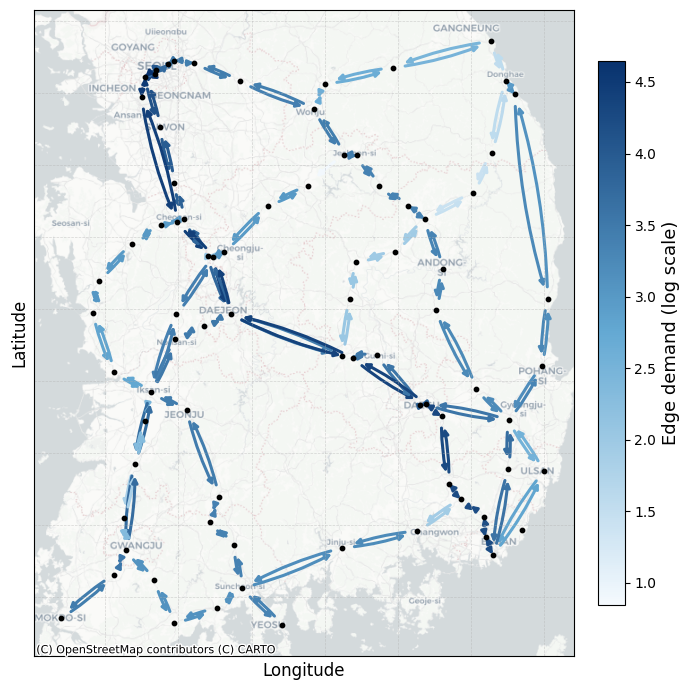

In [14]:
# ───────────────────────── Set paths ─────────────────────────
BASE         = Path(r"D:\MINJI\NETWORK RELIABILITY\QGIS\7.Korea_Full")
xlsx_fp      = BASE / "qgis_export.xlsx"
json_fp      = BASE / r"json\demand_fig.json"      
# -------------------------------------------------------------------------

# 1. Load NODE / EDGE sheets 
node_df = pd.read_excel(xlsx_fp, sheet_name="NODE",
                        usecols=["node_id", "geometry"])
edge_df = pd.read_excel(xlsx_fp, sheet_name="EDGE",
                        usecols=["edge_id", "from_node_id", "to_node_id",
                                 "distance", "geom_line"])

node_gdf = gpd.GeoDataFrame(
    node_df.assign(geometry=node_df["geometry"].apply(wkt.loads)),
    geometry="geometry", crs="EPSG:4326"
).to_crs(epsg=3857)

edge_gdf = gpd.GeoDataFrame(
    edge_df.assign(geometry=edge_df["geom_line"].apply(wkt.loads)),
    geometry="geometry", crs="EPSG:4326"
).to_crs(epsg=3857)

# Coordinates dictionary  { "n1": (x, y) }
nodes = {f"n{int(r.node_id)}": (r.geometry.x, r.geometry.y)
         for r in node_gdf.itertuples(index=False)}

# Bidirectional edge dictionary
edges, arc_dist = {}, {}
for r in edge_gdf.itertuples(index=False):
    u_id, v_id = int(r.from_node_id), int(r.to_node_id)
    u, v       = f"n{u_id}", f"n{v_id}"
    d_km       = float(r.distance)

    eid_fwd = f"{r.edge_id}:{u_id}->{v_id}"
    eid_rev = f"{r.edge_id}:{v_id}->{u_id}"
    edges[eid_fwd], edges[eid_rev] = (u, v), (v, u)
    arc_dist[eid_fwd] = arc_dist[eid_rev] = d_km

# 2. Build DiGraph
G = nx.DiGraph()
for n, xy in nodes.items():
    G.add_node(n, pos=xy)
for eid, (u, v) in edges.items():
    G.add_edge(u, v, weight=arc_dist[eid])

# 3. Parse demand JSON 
with open(json_fp, encoding="utf-8") as f:
    jd = json.load(f)

records = []

if isinstance(jd, list):
    # Format A: [{ "origin": "n1", "destination": "n2", "journeys": 123, ...}, ...]
    for rec in jd:
        o = rec.get("origin") or rec.get("origin_name")
        d = rec.get("destination") or rec.get("destination_name")
        j = rec.get("journeys", 0)
        if o and d:
            records.append((o, d, j))

elif isinstance(jd, dict):
    # Format B: { "LineName": [["n1","n2",123], ...], ... }
    for lst in jd.values():
        for o, d, j in lst:
            records.append((o, d, j))

else:
    raise ValueError("Unsupported JSON structure.")

# 4. Accumulate demand for each edge 
edge_demand = {e: 0.0 for e in G.edges}

for o, d, j in records:
    try:
        paths = list(nx.all_shortest_paths(G, o, d, weight="weight"))
        share = j / len(paths)
        for p in paths:
            for u, v in zip(p[:-1], p[1:]):
                edge_demand[(u, v)] += share
    except nx.NetworkXNoPath:
        print(f"⚠️ No path {o} → {d}")

# 5. Log-scale normalization, colormap 
logd = {e: np.log10(v + 1) for e, v in edge_demand.items()}
dmin, dmax = min(logd.values()), max(logd.values())
normd = {e: (v - dmin) / (dmax - dmin) if dmax > dmin else 0
         for e, v in logd.items()}

cmap = LinearSegmentedColormap.from_list(
    "grad", [(245/255,250/255,254/255),
             (100/255,169/255,211/255),
             (8/255,50/255,110/255)])

# 6. Visualization 
fig, ax = plt.subplots(figsize=(7, 7))
pos = nx.get_node_attributes(G, "pos")

for (u, v), val in normd.items():
    if val == 0:
        continue
    nx.draw_networkx_edges(
        G, pos, edgelist=[(u, v)],
        width=2.2, edge_color=[cmap(val)],
        arrowstyle="-|>", arrowsize=8,
        connectionstyle="arc3,rad=0.07", ax=ax
    )

# ── Draw nodes 
nodes_pc = nx.draw_networkx_nodes(
    G, pos, node_size=10, node_color="black", ax=ax
)
nodes_pc.set_zorder(3)     

ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron,
                crs="EPSG:3857", zorder=0)

sm = mpl.cm.ScalarMappable(cmap=cmap,
        norm=mpl.colors.Normalize(vmin=dmin, vmax=dmax))
sm.set_array([])
plt.colorbar(sm, ax=ax, fraction=0.046, pad=0.04)\
    .set_label("Edge demand (log scale)", fontsize=13)

ax.grid(True, linestyle="--", linewidth=0.5, alpha=0.5)
ax.set_xlabel("Longitude", fontsize=12)
ax.set_ylabel("Latitude", fontsize=12)
plt.tight_layout()
plt.show()

In [ ]:
import gurobipy as gp, pandas as pd
from collections import defaultdict

# ───────────────────────── 0. INPUT
T  = 10
failed_edges = {"e3","e12","e1","e10","e5","e14"}
max_wait = 2
w1, w2, w3 = 1000, 50, 10
CAPACITY = 3
BIG_M = 10**6
SINK = "SINK"                           

edges = {
    "e1": ("n1","n2",1), "e2": ("n2","n3",1),
    "e3": ("n1","n4",2), "e4": ("n4","n3",2),
    "e5": ("n1","n5",2), "e6": ("n5","n6",1),
    "e7": ("n6","n7",1), "e8": ("n7","n3",1),
    "e9": ("n4","n2",1), "e10": ("n2","n1",1), 
    "e11": ("n3","n2",1), "e12": ("n4","n1",2), 
    "e13": ("n3","n4",2), "e14": ("n5","n1",2), 
    "e15": ("n6","n5",1), "e16": ("n7","n6",1), 
    "e17": ("n3","n7",1), "e18": ("n2","n4",1),
}

routes_nodes = {
    "T1":["n1","n2","n3"],
    "T2":["n1","n4","n3"],
    "T3":["n1","n5","n6","n7","n3"],
}
demand = {
    "T1":[("n1","n2",30),("n1","n3",50),("n2","n3",80)],
    "T2":[("n1","n4",50),("n1","n3",60),("n4","n3",100)],
    "T3":[("n1","n5",800),("n1","n6",60),("n1","n7",75),
          ("n1","n3",100),("n5","n6",25),("n5","n7",35),
          ("n5","n3",70),("n6","n7",15),("n6","n3",25),
          ("n7","n3",35)],
}
trains = list(routes_nodes)

nodes = set(n for _, (s,d,_) in edges.items() for n in (s,d))
nodes.add(SINK)                          # ★ SINK 노드 포함

# ───────────────────────── 0-a. 시간확장 아크
arc_list = []                            # (from, to, eid, τ)

# 실제 이동 arc
for eid,(src,dst,tau) in edges.items():
    if eid in failed_edges: continue
    for t in range(T + 1 - tau):
        arc_list.append((f"{src}^{t}", f"{dst}^{t+tau}", eid, tau))

# wait-arc
for n in nodes - {SINK}:
    for w in range(1, max_wait+1):
        for t in range(T + 1 - w):
            arc_list.append((f"{n}^{t}", f"{n}^{t+w}", f"w_{n}_{w}", w))

# ★ dummy-arc : 후보 종착지 n^t → SINK^t  (τ=0)
for n in nodes - {SINK}:
    for t in range(T+1):
        arc_list.append((f"{n}^{t}", f"{SINK}^{t}", f"dummy_{n}", 0))

df_arc = pd.DataFrame(arc_list, columns=["from","to","eid","tau"])

# ───────────────────────── 0-b. 예정 도착시각
sched = {}
for tr, path in routes_nodes.items():
    t = 0; arr = {path[0]: 0}
    for i in range(len(path)-1):
        u,v = path[i], path[i+1]
        eid = next(e for e,(s,d,_) in edges.items() if s==u and d==v)
        t += edges[eid][2]
        arr[v] = t
    sched[tr] = arr

q_r = {tr: sum(q for *_,q in demand[tr]) for tr in trains}

# ───────────────────────── 1. 모델
m = gp.Model(); m.Params.OutputFlag = 0

# 1-a. 변수
x = {(tr, fr, to, eid): m.addVar(vtype=gp.GRB.BINARY)
     for (fr,to,eid,_) in arc_list for tr in trains}

h = {tr: m.addVar(vtype=gp.GRB.BINARY) for tr in trains}

r_T = {tr: set(routes_nodes[tr][1:]) for tr in trains}
y = {(tr,n): m.addVar(vtype=gp.GRB.BINARY)
     for tr in trains for n in r_T[tr]}

s = {(tr,n): m.addVar(vtype=gp.GRB.BINARY)
     for tr in trains for n in nodes - {SINK}}

z = {(tr,o,d): m.addVar(vtype=gp.GRB.BINARY)
     for tr in trains for (o,d,_) in demand[tr]}

delta = {(tr,o,d): m.addVar(lb=0)
         for tr in trains for (o,d,_) in demand[tr]}

t_arr = {(tr,n): m.addVar(lb=0,ub=T,vtype=gp.GRB.INTEGER)
         for tr in trains for n in nodes - {SINK}}

# ───────────────────────── 2. 제약
# (2) x ≤ h
for (tr,*_),var in x.items():
    m.addConstr(var <= h[tr])

# (3) 출발지 순유출
for tr in trains:
    r_o = routes_nodes[tr][0]
    out = gp.quicksum(v for (tr_,fr,*_),v in x.items()
                      if tr_==tr and fr.startswith(f"{r_o}^"))
    m.addConstr(out == h[tr])

# (4★) 종착 후보 선택 & dummy-arc 1개 연결
for tr in trains:
    m.addConstr(gp.quicksum(y[tr,n] for n in r_T[tr]) == h[tr])
    for n in r_T[tr]:
        dummy_sum = gp.quicksum(v for (tr_,fr,to,eid),v in x.items()
                                if tr_==tr and eid==f"dummy_{n}")
        m.addConstr(dummy_sum == y[tr,n])            # ★

# (5) 모든 노드( SINK 제외 ) 시간별 흐름보존
for tr in trains:
    r_o = routes_nodes[tr][0]
    for n in nodes - {SINK}:
        for t in range(T+1):
            nt = f"{n}^{t}"
            inflow  = gp.quicksum(v for (tr_,fr,to,*_),v in x.items()
                                  if tr_==tr and to == nt)
            outflow = gp.quicksum(v for (tr_,fr,to,*_),v in x.items()
                                  if tr_==tr and fr == nt)
            if n==r_o and t==0:        # 출발 노드·시각 = 순유출 = h
                m.addConstr(outflow - inflow == h[tr])
            elif n!=SINK:
                m.addConstr(inflow == outflow)

# (7’)(8’) 실제 in-arc 방문
for (tr, n), var_s in s.items():
    r_o = routes_nodes[tr][0]
    if n == r_o:
        real_flow = gp.quicksum(v for (tr_, fr, to, eid), v in x.items()
                                if tr_ == tr and fr.split("^")[0] == n
                                   and not eid.startswith(("w_", "dummy_")))
    else:
        real_flow = gp.quicksum(v for (tr_, fr, to, eid), v in x.items()
                                if tr_ == tr and to.split("^")[0] == n
                                   and not eid.startswith(("w_", "dummy_")))
    m.addConstr(real_flow >= var_s)
    m.addConstr(real_flow <= BIG_M * var_s)

# (10)~(12)+(15)
for tr in trains:
    for (o,d,_) in demand[tr]:
        m.addConstr(z[tr,o,d] <= s[tr,o])
        m.addConstr(z[tr,o,d] <= s[tr,d])
        m.addConstr(z[tr,o,d] >= s[tr,o] + s[tr,d] - 1)
        m.addConstr(z[tr,o,d] <= h[tr])

# 시간 링크 (dummy 제외)
for (tr,fr,to,eid),v in x.items():
    if eid.startswith(("w_","dummy_")): continue
    node_to, t_to = to.split("^"); t_to=int(t_to)
    m.addConstr(t_arr[tr,node_to] >= t_to - BIG_M*(1-v))
    m.addConstr(t_arr[tr,node_to] <= t_to + BIG_M*(1-v))

# Δ
for tr in trains:
    for (o,d,q) in demand[tr]:
        sched_t = sched[tr].get(d,T)
        m.addConstr(delta[tr,o,d] >= t_arr[tr,d]-sched_t - BIG_M*(1-z[tr,o,d]))
        m.addConstr(delta[tr,o,d] <= BIG_M*z[tr,o,d])

# (6) 용량 (dummy/wait 제외)
for eid,(src,dst,tau) in edges.items():
    if eid in failed_edges: continue
    for tt in range(T):
        flow = gp.quicksum(v for (tr,fr,to,e),v in x.items()
                           if e==eid and
                              int(fr.split("^")[1])<=tt<int(to.split("^")[1]))
        m.addConstr(flow <= CAPACITY)

# ───────────────────────── 3. 목적식
obj  = gp.quicksum(w1*q_r[tr]*(1-h[tr]) for tr in trains)
obj += gp.quicksum(w2*q*(1-z[tr,o,d])
                   for tr in trains for (o,d,q) in demand[tr])
obj += gp.quicksum(w3*q*delta[tr,o,d]*z[tr,o,d]
                   for tr in trains for (o,d,q) in demand[tr])
m.setObjective(obj, gp.GRB.MINIMIZE)

m.optimize()

# ───────────────────────── 4. 시간표 출력
rows=[]
for tr in trains:
    if h[tr].X<0.5:
        rows.append([tr,'-','-','-','-','Cancelled']); continue
    legs=[(int(fr.split("^")[1]),fr.split("^")[0],
           to.split("^")[0],int(to.split("^")[1]),eid)
          for (tr_,fr,to,eid),v in x.items()
          if tr_==tr and v.X>0.5 and not eid.startswith(("w_","dummy_"))]
    legs.sort(key=lambda k:k[0])
    for dep,frm,to,arr,eid in legs:
        rows.append([tr,frm,dep,to,arr,eid])

df=pd.DataFrame(rows,columns=["Train","From","Dep","To","Arr","Edge"])
print("\n=== Timetable (chronological) ===")
print(df.to_string(index=False))

# ───────────────────────── 5-A. objective breakdown
cancel_pen = sum(w1*q_r[tr]*(1-h[tr].X) for tr in trains)

unmet_pen  = sum(w2*q*(h[tr].X - z[tr,o,d].X)
                 for tr in trains for (o,d,q) in demand[tr])

delay_pen  = sum(w3*q*delta[tr,o,d].X*z[tr,o,d].X
                 for tr in trains for (o,d,q) in demand[tr])

print(f"\n=== Objective breakdown ===")
print(f"  Cancellation penalty : {cancel_pen:,.0f}")
print(f"  Un-served demand     : {unmet_pen:,.0f}")
print(f"  Delay penalty        : {delay_pen:,.0f}")
print(f"--------------------------------")
print(f"  Total objective      : {m.ObjVal:,.0f}")


# ───────────────────────── 5-B. train-level status
status_rows = []
for tr in trains:
    if h[tr].X < 0.5:
        status = "Cancelled"
    else:
        delayed = any(delta[tr,o,d].X > 1e-6 for (o,d,_) in demand[tr])
        unmet   = any(z[tr,o,d].X < 0.5 for (o,d,_) in demand[tr])
        if delayed:
            status = "Delayed"
        elif unmet:
            status = "Truncated/Rerouted"
        else:
            status = "On-time & complete"
    status_rows.append([tr, status])

df_stat = pd.DataFrame(status_rows, columns=["Train", "Status"])
print("\n=== Train status summary ===")
print(df_stat.to_string(index=False))



=== Timetable (chronological) ===
Train From Dep To Arr      Edge
   T1    -   -  -   - Cancelled
   T2    -   -  -   - Cancelled
   T3    -   -  -   - Cancelled

=== Objective breakdown ===
  Cancellation penalty : 1,610,000
  Un-served demand     : 0
  Delay penalty        : 0
--------------------------------
  Total objective      : 1,690,500

=== Train status summary ===
Train    Status
   T1 Cancelled
   T2 Cancelled
   T3 Cancelled
